## library

In [1]:
setwd('/datd/zorro/projects/NonEpiMutation')
source("/home/zorro/scripts/Rscripts/Seurat_Functions_V5.r")

Warning message:
"package 'gridExtra' was built under R version 4.0.5"
Warning message:
"package 'ggplot2' was built under R version 4.0.5"
Warning message:
"package 'RColorBrewer' was built under R version 4.0.5"
Warning message:
"package 'dplyr' was built under R version 4.0.5"
Warning message:
"package 'tidyr' was built under R version 4.0.5"
Warning message:
"package 'stringr' was built under R version 4.0.5"
Warning message:
"package 'reshape2' was built under R version 4.0.5"
Warning message:
"package 'tibble' was built under R version 4.0.5"
Warning message:
"package 'paletteer' was built under R version 4.0.5"
Warning message:
"package 'Rcpp' was built under R version 4.0.5"
Warning message:
"package 'future' was built under R version 4.0.5"


## load Germline data & filtering

### raw data

In [7]:
load( "./00.processed.data/01.sample_filtered/PBMC_Germline_base.rdata" )
load( "./00.processed.data/01.sample_filtered/PBMC_Germline_samples_summary.rdata" )

In [8]:
PBMC_Germline_Mutation.df <- PBMC_Germline@data %>% left_join( PBMC.SampleInfo %>% mutate( Tumor_Sample_Barcode = as.vector(Tumor_Sample_Barcode) ) ) %>% mutate( Tumor_Sample_Barcode = factor(Tumor_Sample_Barcode, ordered = T, levels = PBMC_Sample_Barcode.order) ) %>% mutate( mutation_id = paste( Hugo_Symbol, Chromosome, Start_Position, HGVSp_Short, sep = "_" ) )

Joining, by = "Tumor_Sample_Barcode"


In [29]:
## filtering
PBMC_Germline_Mutation.Summary <- PBMC_Germline_Mutation.df %>% group_by( Patient, mutation_id ) %>% summarise( chr = unique(Chromosome), Counts_SamplePerPatient = n(), MeanVaf_SamplePerPatient = mean(t_vaf) ) %>% as.data.frame
# PBMC_Germline_Mutation.Summary.filter <- PBMC_Germline_Mutation.Summary %>% filter( (chr!="chrX" & MeanVaf_SamplePerPatient<=.4) | (chr=="chrX" & MeanVaf_SamplePerPatient<=.8) )
PBMC_Germline_Mutation.Summary.filter <- PBMC_Germline_Mutation.Summary %>% filter( MeanVaf_SamplePerPatient<=.4 & !(chr %in% c("chrX","chrY")) )

PBMC_Germline_Mutation.df.filter <- PBMC_Germline_Mutation.df %>% inner_join( PBMC_Germline_Mutation.Summary.filter )

`summarise()` has grouped output by 'Patient'. You can override using the `.groups` argument.
Joining, by = c("Patient", "mutation_id")


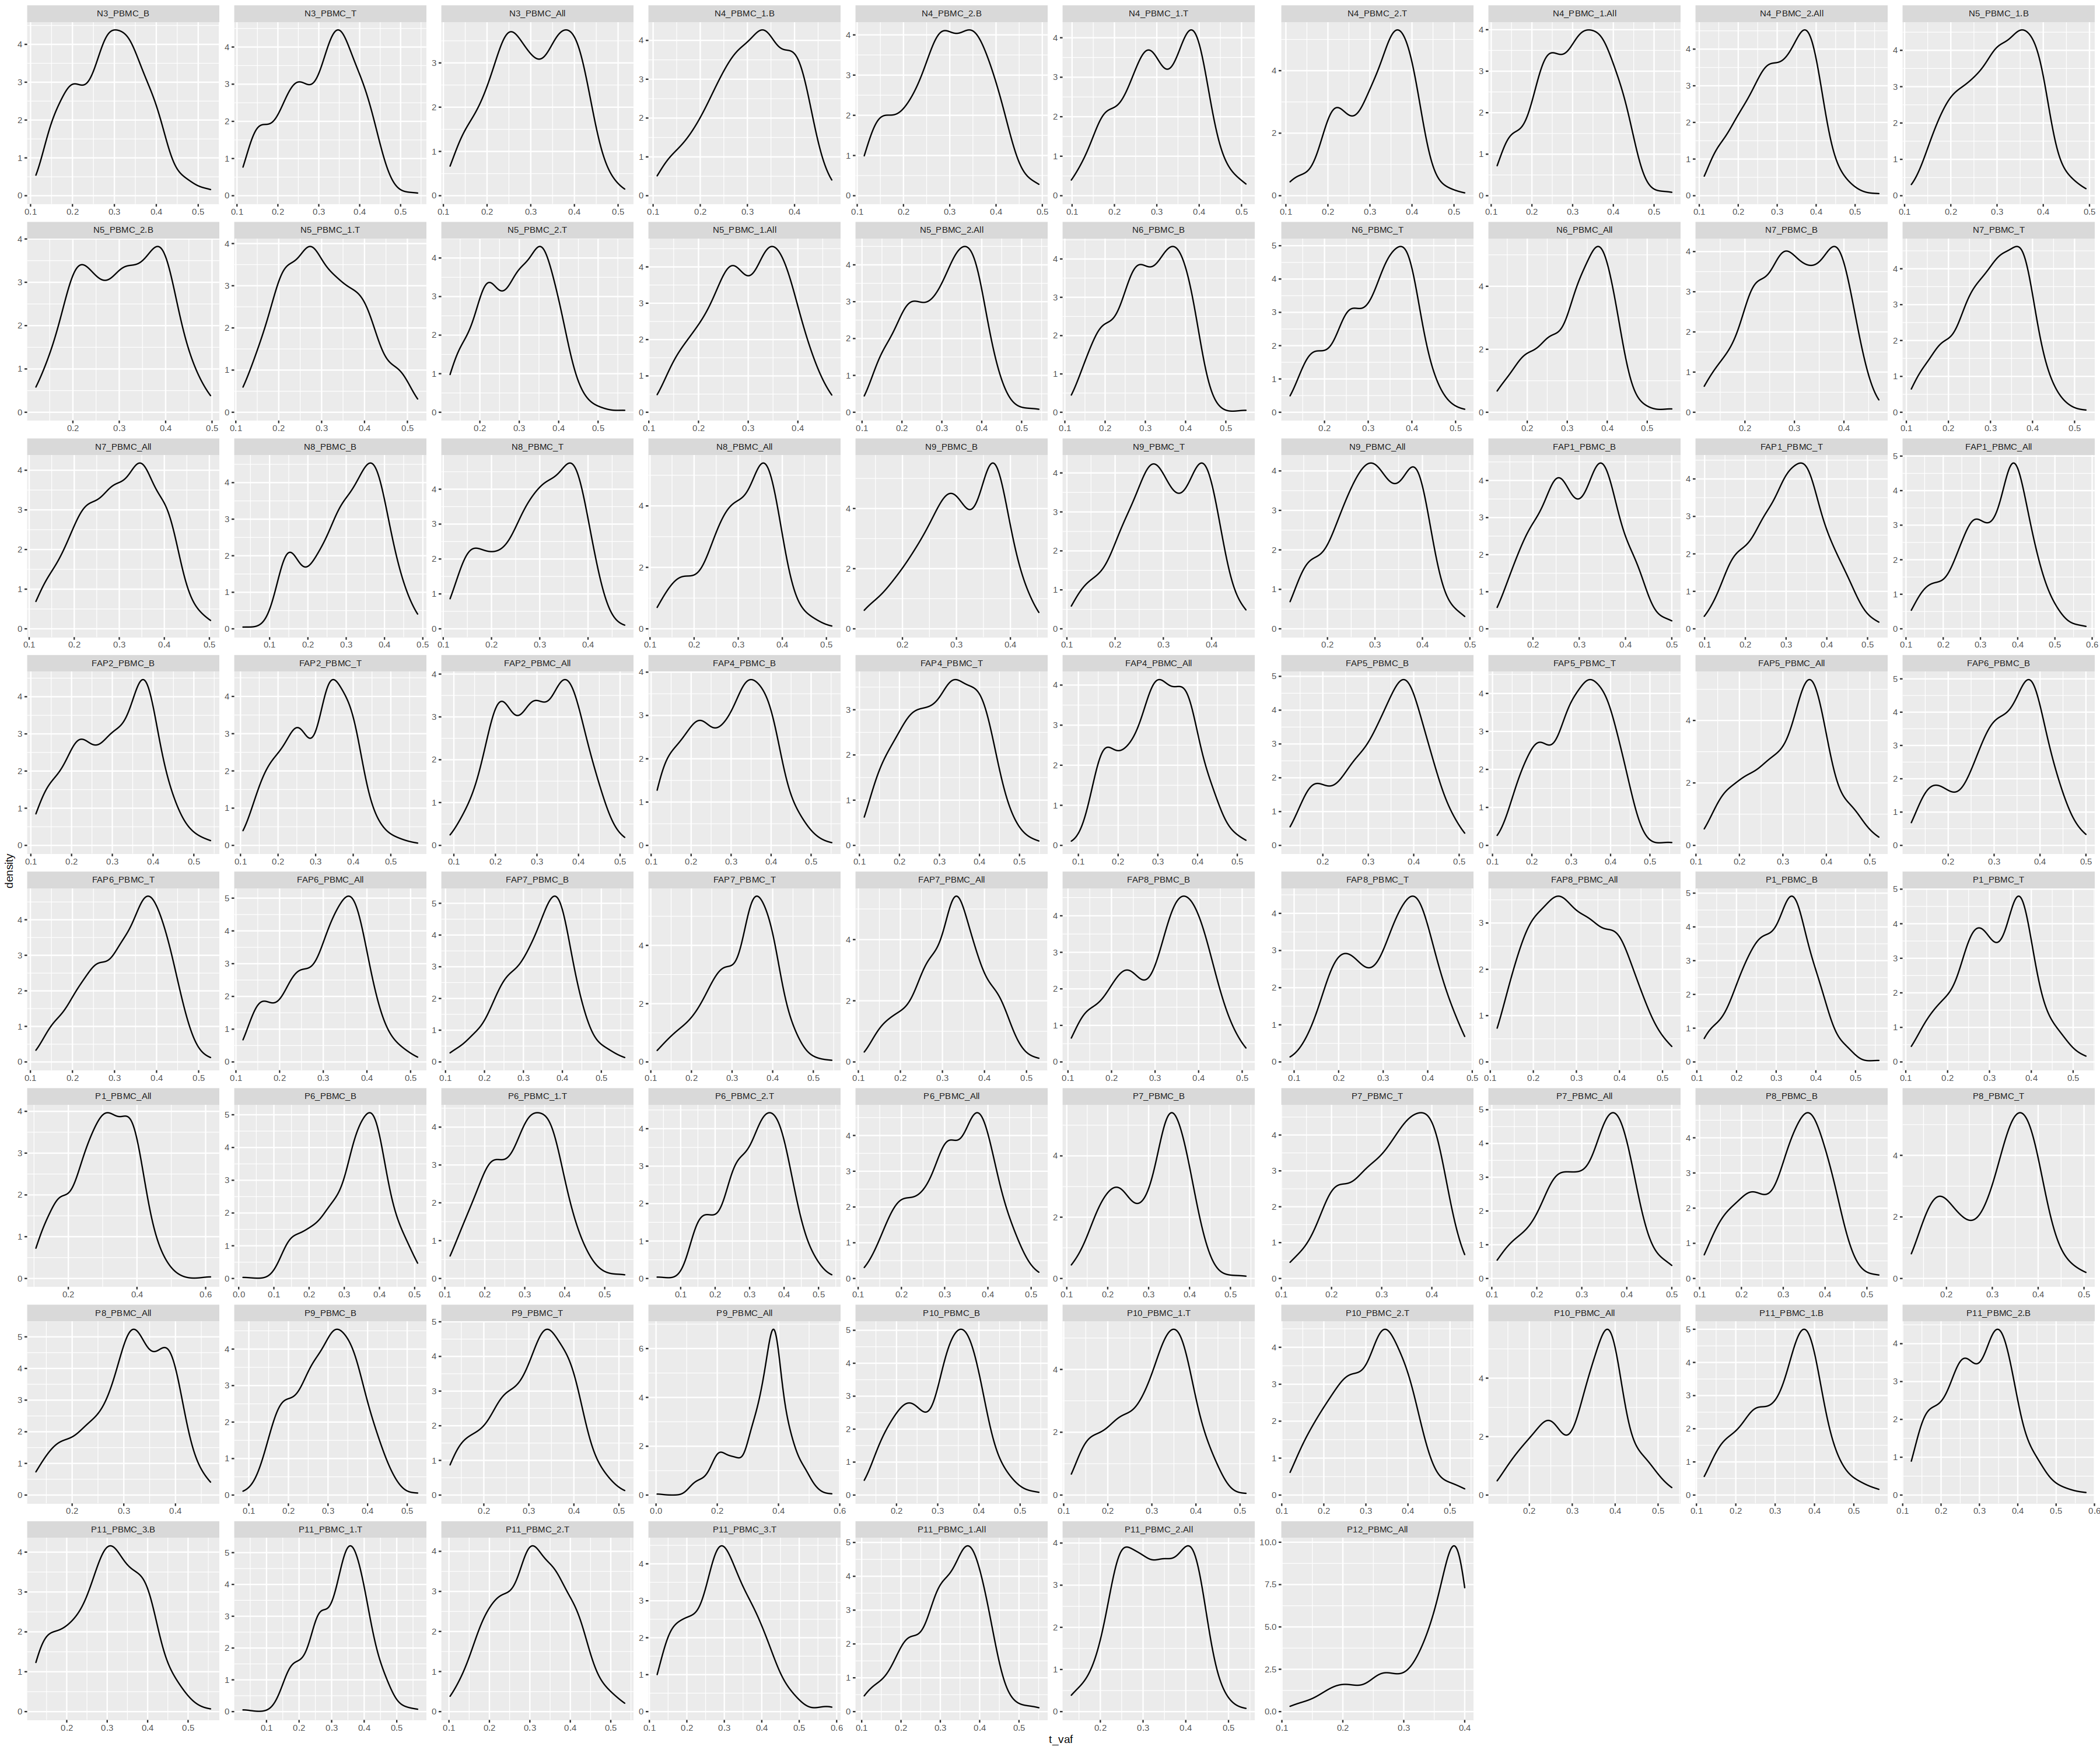

In [30]:
setfig( 30, 25 )
PBMC_Germline_Mutation.df.filter %>% ggplot( ., aes( x=t_vaf ) ) + geom_density() + facet_wrap( ~Tumor_Sample_Barcode, ncol = 10, scales = "free" )

In [32]:
PBMC_Germline_Mutation.df.filter$Tumor_Sample_Barcode %>% table

.
     N3_PBMC_B      N3_PBMC_T    N3_PBMC_All    N4_PBMC_1.B    N4_PBMC_2.B 
           406            404            403            350            274 
   N4_PBMC_1.T    N4_PBMC_2.T  N4_PBMC_1.All  N4_PBMC_2.All    N5_PBMC_1.B 
           316            321            347            340            331 
   N5_PBMC_2.B    N5_PBMC_1.T    N5_PBMC_2.T  N5_PBMC_1.All  N5_PBMC_2.All 
           348            328            346            329            352 
     N6_PBMC_B      N6_PBMC_T    N6_PBMC_All      N7_PBMC_B      N7_PBMC_T 
           339            338            318            372            359 
   N7_PBMC_All      N8_PBMC_B      N8_PBMC_T    N8_PBMC_All      N9_PBMC_B 
           352            351            355            347            342 
     N9_PBMC_T    N9_PBMC_All    FAP1_PBMC_B    FAP1_PBMC_T  FAP1_PBMC_All 
           376            360            444            472            617 
   FAP2_PBMC_B    FAP2_PBMC_T  FAP2_PBMC_All    FAP4_PBMC_B    FAP4_PBMC_T 
          

### filtering

In [11]:
suppressPackageStartupMessages(library( VGAM ))
suppressPackageStartupMessages( library(reticulate) )

python.scipy.stats <- import( "scipy.stats" )

Warning message:
"package 'reticulate' was built under R version 4.0.5"


In [105]:
PBMC_betabinom_test_out <- structure( map( levels(PBMC_Germline_Mutation.df.filter$Tumor_Sample_Barcode), function(X) {
    
    in.data <- PBMC_Germline_Mutation.df.filter %>% filter( Tumor_Sample_Barcode==X )
    in.fit.shape <- invisible( vglm(cbind(t_alt_count, t_depth - t_alt_count) ~ 1, betabinomialff, trace = FALSE, data = in.data ))
    in.fit.rho <- invisible( vglm(cbind(t_alt_count, t_depth - t_alt_count) ~ 1, betabinomial, trace = FALSE, data = in.data ))
    in.fit.rho_residuals <- in.fit.rho@residuals %>% as.data.frame %>% setNames( c("logitlink_mut","logitlink_rho") )
    
    alpha <- Coef(in.fit.shape)[[1]]
    beta <- Coef(in.fit.shape)[[2]]
         
    in.data %>% mutate( beta.binom.pvalue = 1-round(python.scipy.stats$betabinom$cdf( t_alt_count-0.1, t_depth, alpha, beta ),4) ) %>% dplyr::select( Hugo_Symbol, Chromosome, Start_Position, Variant_Classification, Variant_Type, Tumor_Sample_Barcode, HGVSp_Short, MergeCelltype, mutation_id, t_alt_count, t_depth, t_vaf, beta.binom.pvalue ) %>% cbind( ., in.fit.rho_residuals ) %>% as.data.frame
    
} ), names = levels(PBMC_Germline_Mutation.df.filter$Tumor_Sample_Barcode) )

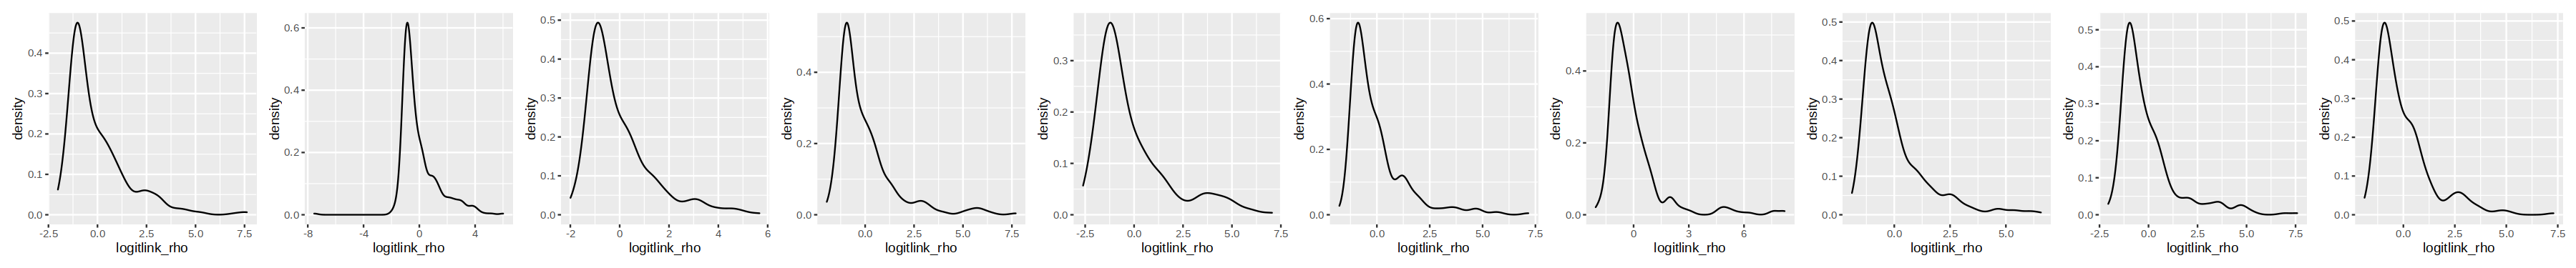

In [158]:
## beta binomal filtering

setfig( 30, 25/8 )
map( PBMC_betabinom_test_out, function(X) ggplot(X, aes(x=logitlink_rho)) + geom_density() ) %>% head(10) %>% wrap_plots( ., ncol = 10 )
    PBMC_betabinom_filter <- map( PBMC_betabinom_test_out, ~.x %>% filter( logitlink_rho>0 ) ) %>% do.call( rbind, . ) %>% as.data.frame

In [182]:
## high-frequency mutation filtering

suppressPackageStartupMessages( library(diptest) )
suppressPackageStartupMessages(library( LaplacesDemon ))

filtered_mutation_ids <- PBMC_betabinom_filter %>% filter( mutation_id %in% (PBMC_betabinom_filter %>% group_by( mutation_id ) %>% summarise( count = n() ) %>% as.data.frame %>% filter( count>=5 ) %>% .$mutation_id) ) %>% group_by( mutation_id ) %>% summarise( dip.test_p.value = suppressWarnings(dip.test(t_vaf)$p.value), unimodal_test = is.unimodal(t_vaf) ) %>% as.data.frame %>% filter( dip.test_p.value<=0.05 | unimodal_test ) %>% .$mutation_id

PBMC_SomaticMutation_retained <- PBMC_betabinom_filter %>% filter( !(mutation_id %in% filtered_mutation_ids) )

In [6]:
## the above filtering

load( "./00.processed.data/01.sample_filtered/PBMC_Germline_base.rdata" )
load( "./00.processed.data/01.sample_filtered/PBMC_Germline_samples_summary.rdata" )

PBMC_Germline@data %<>% mutate( unique_mutation_id = paste( Tumor_Sample_Barcode, Hugo_Symbol, Chromosome, Start_Position, HGVSp_Short, sep = "_" ) )
PBMC_SomaticMutation_retained <- readRDS( file = "./00.processed.data/07.PBMC_Somatic/07.PBMC_Somatic_retained_filtered.rds" ) %>% mutate( unique_mutation_id = paste0( Tumor_Sample_Barcode, "_", mutation_id ) )

In [7]:
## remove population SNVs

PBMC_Germline_info <- read.delim2( "./00.raw.data.retained/PBMC_retained_MergedSamples_GermlineSNVs_vcf2maf_anno.maf", skip = 1 )
PBMC_Germline_info %<>% mutate( unique_mutation_id = paste( Tumor_Sample_Barcode, Hugo_Symbol, Chromosome, Start_Position, HGVSp_Short, sep = "_" ) )
PBMC_Germline_info.retained <- PBMC_Germline_info %>% filter( unique_mutation_id %in% PBMC_SomaticMutation_retained$unique_mutation_id ) %>% dplyr::select( -unique_mutation_id )

In [8]:
Retained_Mutation_id_BasedOn_Ratio <- PBMC_Germline_info.retained %>% mutate( mutation_id = paste( Hugo_Symbol, Chromosome, Start_Position, HGVSp_Short, sep = "_" ) ) %>% group_by( Hugo_Symbol, mutation_id ) %>% summarise( Mutant_Count = n() ) %>% as.data.frame %>% group_by( Hugo_Symbol ) %>% mutate( Gene_Count = sum(Mutant_Count) ) %>% as.data.frame %>% mutate( Mutant_Ratio = Mutant_Count/Gene_Count ) %>% filter( !(Gene_Count>=8 & Mutant_Ratio>=.5) ) %>% .$mutation_id

`summarise()` has grouped output by 'Hugo_Symbol'. You can override using the
`.groups` argument.


In [9]:
#### V3 - 0.5 with remove main mutation
Somatic_retained_genes <- PBMC_Germline_info.retained %>% group_by( Hugo_Symbol ) %>% summarise( Paient_Num = length(unique(Tumor_Sample_Barcode)) ) %>% as.data.frame %>% mutate( Patient_Ratio = Paient_Num/length(unique(PBMC_Germline_info.retained$Tumor_Sample_Barcode)) ) %>% filter( Patient_Ratio<0.5 ) %>% .$Hugo_Symbol
PBMC_Germline_info.retained.remove_pop3 <- PBMC_Germline_info.retained %>% mutate( mutation_id = paste( Hugo_Symbol, Chromosome, Start_Position, HGVSp_Short, sep = "_" ) ) %>% filter( Hugo_Symbol %in% Somatic_retained_genes, mutation_id %in% Retained_Mutation_id_BasedOn_Ratio ) %>% mutate( t_vaf = t_alt_count/t_depth ) %>% filter( t_vaf<.5 ) %>% dplyr::select( -mutation_id )  

In [9]:
PBMC_Somatic <- read.maf( maf = "./00.processed.data/07.PBMC_Somatic/PBMC_retained_MergedSamples_filtered_SomaticSNVs_RemovePop_V0.5_And_RemoveMainMutant_vcf2maf_anno.maf", 
                          clinicalData = "./00.raw.data.retained/PBMC_retained_MergedSamples_GermlineSNVs_vcf2maf_anno.txt")

PBMC_Somatic@data %<>% mutate( unique_mutation_id = paste( Tumor_Sample_Barcode, Hugo_Symbol, Chromosome, Start_Position, HGVSp_Short, sep = "_" ) ) %>% left_join( PBMC_Somatic@clinical.data ) %>% mutate( Tumor_Sample_Barcode = factor( Tumor_Sample_Barcode, ordered = T, levels = PBMC_Sample_Barcode.order ) )

PBMC_Sample_Barcode.order_bytypes <- PBMC_Somatic@clinical.data %>% mutate( MergeCelltype = factor(MergeCelltype, ordered = T, levels = names(PBMC_Celltype_colors)) ) %>% arrange( MergeCelltype ) %>% .$Tumor_Sample_Barcode

PBMC_Somatic_list <- list(
    B_in_blood = subsetMaf( maf = PBMC_Somatic, clinQuery = "MergeCelltype=='B_in_blood'" ),
    T_in_blood = subsetMaf( maf = PBMC_Somatic, clinQuery = "MergeCelltype=='T_in_blood'" ),
    Whole_blood = subsetMaf( maf = PBMC_Somatic, clinQuery = "MergeCelltype=='Whole_blood'" )
)

-Reading
-Validating
-Summarizing
-Processing clinical data
-Finished in 0.420s elapsed (0.581s cpu) 


Joining, by = "Tumor_Sample_Barcode"
-subsetting by clinical data..

--25 samples meet the clinical query

-subsetting by clinical data..

--27 samples meet the clinical query

-subsetting by clinical data..

--25 samples meet the clinical query



In [29]:
PBMC_Somatic@data %>% dim
PBMC_Somatic@data %>% .$Tumor_Sample_Barcode %>% unique %>% length
PBMC_Somatic@data$Hugo_Symbol %>% unique %>% length

PBMC_Somatic@clinical.data %>% .$Patient %>% substr( ., 1, 1 )  %>% table
PBMC_Somatic@clinical.data %>% .$MergeCelltype %>% table

[1] 3394  139

[1] 77

[1] 1317

.
 F  N  P 
21 27 29 

.
 B_in_blood  T_in_blood Whole_blood 
         25          27          25 